## Setup

First, we need to setup an access to *Google Drive*. This is to persist data or artifacts in a local drive even when we are not connected to *Google Colab*.

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Then, install `fastai` as necessary dependencies and import them.

In [2]:
!python -m pip install -Uqq ipywidgets fastai

In [3]:
from fastai.vision.all import *

## Introduction

### Why Deep Learning?

This is a starting point to your deep learning journey. Before we dive into what you need to know about it and how, it is important to talk about **Why?**.

* **It is for everyone:** One might say deep learning is like a blackbox. However, the truth is in practice, what you want to do is just to solve problem of your own interests and there are a lot of state-of-the-art models to help you do that.
* **Huge amount of data:** A lot of open-source and pre-trained model out there! So, there is no need for you to start collecting data from scratch just a few samples of it.
* **High computational resources:** You do not need to be *Google* or *Microsoft* to train such large models. Nowadays, everyone can access this kind of computational resouce for free.
* **Good for thousands of use cases in different areas:** There are remarkable accomplishment throughout the recent years that deep learning helps researchers and practitioners solve. Here is some of them:
    * Natural language processing (NLP): answering questions; speech recognition; summarizing documents; classifying documents; translation;information retrieval (searching). Here is my recommendation on [a comprehensive guide to NLP](https://www.deeplearning.ai/resources/natural-language-processing/).
    * Computer vision: image recognition; image captioning; image segmentation; image generation.
    * Recommendation systems: product recommendations; web searching.
    * Games: chess; go; real-time strategy games like StarCrafts.
    * Others: algoritmic trading; text-to-speech.

### Neural Networks: A Brief History

This is a simplified verison of ANNs history that you will help you contextualize on what we have been through and learn to not repeat some of it!

```mermaid
flowchart LR;
    A[Artificial Neurons] -- Unrecognized social position --> B[Perceptrons] -- Failure to learn simple XOR --> C[PDP] -- Approximation with one extra layer --> D[Modern ANNs];
```

Basically, what researchers have tried to do since 1943 is to develop a mathematical model of an artificial neuron inspired by the human brain. Although there are several years of misunderstanding of the theoretical issues, we still have multi-volume Parallel Distributed Processing (PDP) which acts as a backbone of modern ANNs. Here is the required components for this framework:

1. A set of processing units
2. A state of activation
3. An output function for each unit
4. A pattern of connectivity among units
5. A propagation rule for propagating patterns of activities through the network of connectivities
6. An activation rule for combining the inputs impinging on a unit with the current state of that unit to produce an output for the unit
7. A learning rule whereby patterns of connectivity are modified by experience
8. An environment within which the system must operate

Again, thanks to the use of more layers, together with the improvement in hardware capability, the increase amount of data and algorithmic tweaks that allow neural networks to be trained faster and more easily, We now are able to complete complex tasks like an image recognizer by a only computer.

## Cats and Dogs

Let's implement *PDP* framework in practice by using a *pre-trained model* to complete a task; an image recognizer perhaps. Here is what about to happen:

1. A dataset called the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) that contains 7,349 images of cats and dogs from 37 different breeds will be downloaded from the fast.ai datasets collection to the GPU server you are using, and will then be extracted.
2. A *pretrained model* that has already been trained on 1.3 million images, using a competition-winning model will be downloaded from the internet.
3. The pretrained model will be *fine-tuned* using the latest advances in transfer learning, to create a model that is specially customized for recognizing dogs and cats.

In [4]:
path = untar_data(URLs.PETS)/'images'

is_cat = lambda x: x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 90.6MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.163383,0.030820,0.012179,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.055516,0.037565,0.012855,01:00


:::{.callout-important}
Depending on your network speed, it might take a few minutes to download the pretrained model and dataset. Running `fine_tune` might take a minute or so. Often models in this book take a few minutes to train, as will your own models, so it's a good idea to come up with good techniques to make the most of this time. For instance, keep reading the next section while training your model, or open up another notebook and use it for some coding experiments.
:::

After we have trained the model, we need to check if it can do something useful right? There are several ways we can do. The first way is to create an uploader for an interaction. This way is the simplest and suitable for users similiarized with *GUI*.

In [10]:
from ipywidgets import FileUpload

uploader = FileUpload()
uploader

FileUpload(value={}, description='Upload')

Or you can just past in a download link to `download_image` function provided by `fastai` library.

In [20]:
dest = Path("gdrive/My Drive/practical-deep-learning/bin/")
download_images(dest, urls=["https://i.icanvas.com/COC490?d=3&sh=v&s=xl&p=1&bg=g&t=1648830566"])

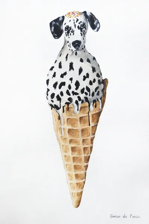

In [23]:
img = PILImage.create("/content/gdrive/MyDrive/practical-deep-learning/bin/75083824-ac57-46d2-acdb-2e0678aba62f.jpg")
img.to_thumb(224)

In [27]:
is_cat, _, probs = learn.predict(img)

print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1]:.4f}")

Is this a cat?: False.
Probability it's a cat: 0.0357


As you can see, this is the power of a pre-trained model!

But how can you tie back into *PDP* frameworks? Let's look into it.

### What Is Machine Learning?

*Machine learning* is, like regular programming, a way to get computers to complete a specific task. The difference is:

> Ability to learn without explitcitly being programmed

Here is [an introduction to machine learning](https://vas3k.com/blog/machine_learning/) that I find easily to get started. This blog includes main concept and its real-world examples.